In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [13]:
seen_df = pd.read_csv('data/0_labelled_documents.csv')
seen_df = seen_df[pd.notna(seen_df['INCLUDE'])]
seen_df["seen"] = 1
unseen_df = pd.read_csv('data/0_unlabelled_documents.csv')
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head()

(531168, 148)


,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,6 - 4.07. Other institutions or agencies,6 - 2.05. Price controls,6 - 4.05. Policy Coordination,6 - 4.09. Other institutions or agencies,6 - 2.11. Non-Tradeable Intensity standards,random,seen,wosarticle__de,wosarticle__wc,relevant
0,339872,Basis for Extending Long-Term Streamflow Forec...,The National Weather Service (NWS) maintains a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Streamflow; Forecasting; Water supply; Sea sur...,"['Engineering, Civil; Environmental Sciences; ...",0.0
1,429592,The biomethane potential in Chile,Within the last decade natural gas gained cons...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Biogas; Bio-SNG; Biomass; Gas pipeline infrast...,['Agricultural Engineering; Biotechnology & Ap...,0.0
2,315503,On the difference in the net ecosystem exchang...,The southeastern United States is experiencing...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,carbon flux; drought; eddy covariance; evapotr...,['Biodiversity Conservation; Ecology; Environm...,0.0
3,1880244,Increasing the stability of Mg-2(dobpdc) metal...,"Mg-2(dopbdc) (H-4-dobpdc = 4,4'-dihydroxy-(1,1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,"['Chemistry, Multidisciplinary']",0.0
4,770174,Are denser cities greener? Evidence from China...,Whether a city develops into a more compact on...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Urban density; air quality; carbon emissions; ...,['Environmental Sciences; Environmental Studies'],0.0


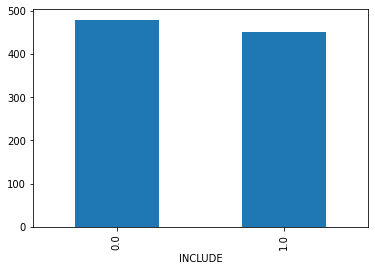

In [3]:
seen_df.groupby('INCLUDE').size().plot.bar()

In [14]:
revectorize = True

X_exists = os.path.isfile(f'data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=10, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )
    vec.fit(seen_df['content'].astype("str"))
    X = vec.transform(df['content'].astype("str"))   
    with open (f'data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(531168, 3464)

In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import random


y = df['INCLUDE']


from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

clf_models = [
    {
        'title': 'SVM rbf', 
        'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
    },
    {
        'title': 'SVM lin C10', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=10)
    },
    {
        'title': 'SVM lin C1', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=1)
    },

]


clf_models, df = lu.cross_validate_models(
    X, y, clf_models, seen_index, n_splits=6, df = df
)

1
2
3
4
5
6


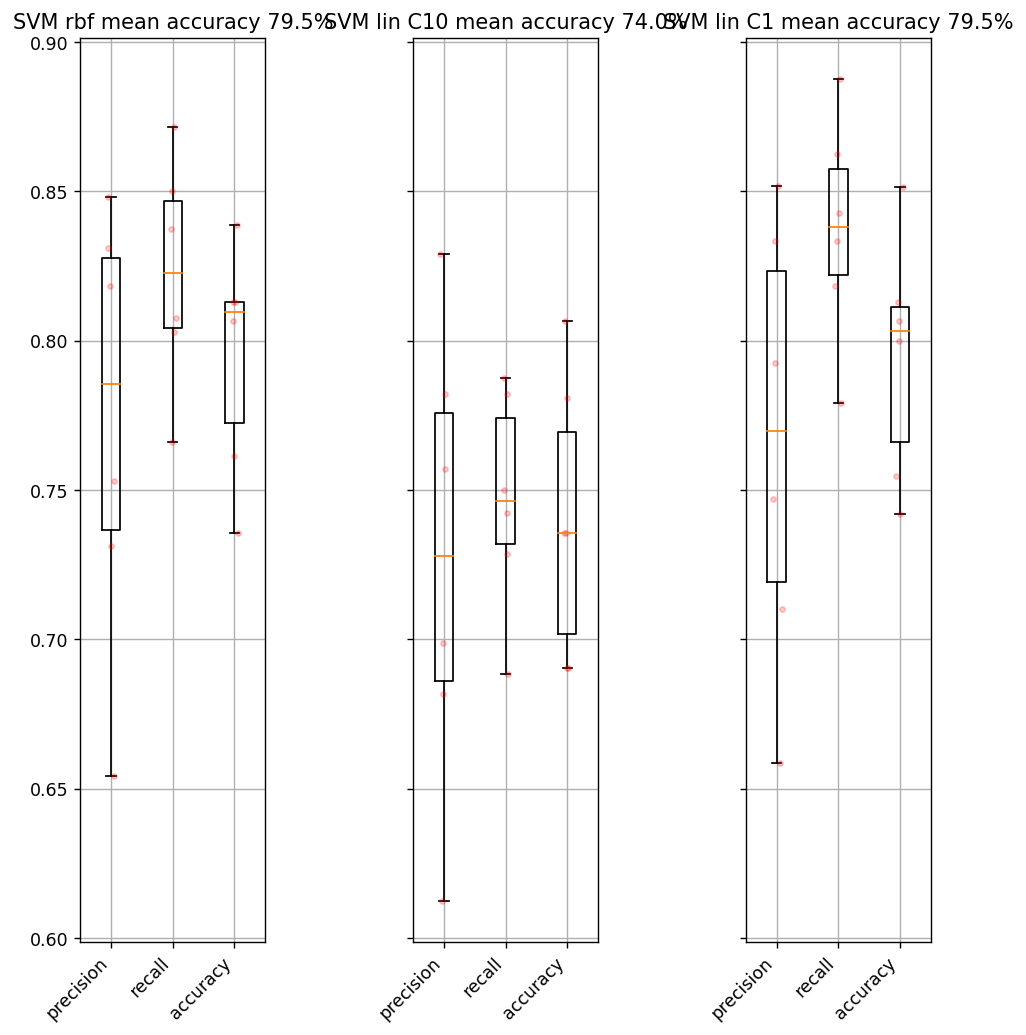

In [16]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()

In [17]:
clf = SVC(kernel='rbf',C=10, class_weight='balanced', probability=True)

clf.fit(X[seen_index],y[seen_index])

y_pred = clf.predict_proba(X[unseen_index])

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


78884


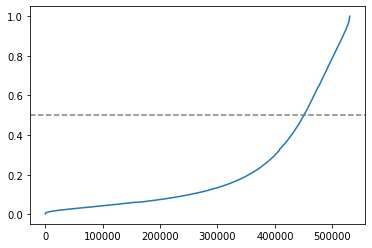

In [18]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [20]:
pairs = [
    (['vasudevan@mcc-berlin.net','galm'], 40),      
    (['ceposadap@gmail.com','edmondson@hertie-school.org'], 20),   
    (['lucy.banisch@icloud.com','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 10",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [5]:
gov_docs = set([1,2,3,4,5,6,7,10,55,22,77])

pairs = [("a,b"),("c,d")]

for i, did in enumerate(gov_docs):
    print(i,did)
    print(i%2)
    pair = pairs[i%2]
    print(pair)
    

0 1
0
a,b
1 2
1
c,d
2 3
0
a,b
3 4
1
c,d
4 5
0
a,b
5 6
1
c,d
6 7
0
a,b
7 10
1
c,d
8 77
0
a,b
9 22
1
c,d
10 55
0
a,b


In [22]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=9046)
tag, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()


users = q.users.all()
uc = len(users)

new_docs = (df
            .sort_values('prediction',ascending=False)
            .head(50)
            .reset_index(drop=True)
           )

for i, row in new_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    u = users[i % uc]
    for u in users:
        do, created = DocOwnership.objects.get_or_create(
            doc=d,
            user=u,
            query=q,
            tag=tag
        )
        do.save()
    
tag.update_tag()